## Probability Calibration with re-sampling techniques

In this notebook, we will re-calibrate probabilities after training models using re-sampling techniques.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss, roc_auc_score

# calibration
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

# resampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import BorderlineSMOTE

import warnings
warnings.filterwarnings("ignore")

## Load imbalanced dataset

In [2]:
# load imbalanced dataset

data = pd.read_csv('../kdd2004.csv')
# remap target class to 0 and 1
data['target'] = data['target'].map({-1:0, 1:1})

In [3]:
# separate dataset into train and test

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),  # drop the target
    data['target'],  # just the target
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((102025, 74), (43726, 74))

In [4]:
# balancing ratio

y_train.value_counts() / len(X_train)

0    0.991267
1    0.008733
Name: target, dtype: float64

## Set up Machine Learning Models

In [5]:
# Random Forests

rf = RandomForestClassifier(
    n_estimators=100, random_state=0, max_depth=2, n_jobs=4)


# Logistic Regression

logit = LogisticRegression(
    penalty='l2',
    solver='newton-cg',
    random_state=0,
    max_iter=10,
    n_jobs=4
)

## Re-sample training set

In [6]:
# Undersampling

rus = RandomUnderSampler(
    sampling_strategy='auto',  # samples only from majority class
    random_state=0,  # for reproducibility
    replacement=True # if it should resample with replacement
)  

X_rus, y_rus = rus.fit_resample(X_train, y_train)
print(y_rus.value_counts())

# Borderline SMOTE

sm_b1 = BorderlineSMOTE(
    sampling_strategy='auto',  # samples only the minority class
    random_state=0,  # for reproducibility
    k_neighbors=5,
    m_neighbors=10,
    kind='borderline-1',
    n_jobs=4
)

X_sm, y_sm = sm_b1.fit_resample(X_train, y_train)
print(y_sm.value_counts())

1    891
0    891
Name: target, dtype: int64
1    101134
0    101134
Name: target, dtype: int64


## Model Performance

In [7]:
for model in [logit, rf]:
    
    print('Raw data')
    # raw dataset: train and predict    
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_test)[:, 1]
    
    # print roc-aucand brier score
    print('roc-auc of ', type(model).__name__, roc_auc_score(y_test, probs))
    print('Brier Score of ', type(model).__name__, brier_score_loss(y_test, probs))
    print()
    
    print('Undersampling')
    # undersamples: train and predict    
    model.fit(X_rus, y_rus)
    probs = model.predict_proba(X_test)[:, 1]
    
    # print roc-aucand brier score
    print('roc-auc of ', type(model).__name__, roc_auc_score(y_test, probs))
    print('Brier Score of ', type(model).__name__, brier_score_loss(y_test, probs))
    print()
    
    print('SMOTE')
    # Smote: train and predict    
    model.fit(X_sm, y_sm)
    probs = model.predict_proba(X_test)[:, 1]
    
    # print roc-aucand brier score
    print('roc-auc of ', type(model).__name__, roc_auc_score(y_test, probs))
    print('Brier Score of ', type(model).__name__, brier_score_loss(y_test, probs))
    print('====')
    print()

Raw data
roc-auc of  LogisticRegression 0.9256916712192443
Brier Score of  LogisticRegression 0.004304728622556127

Undersampling
roc-auc of  LogisticRegression 0.9759906024535189
Brier Score of  LogisticRegression 0.05407280933045367

SMOTE
roc-auc of  LogisticRegression 0.9746609932570554
Brier Score of  LogisticRegression 0.04269835740922695
====

Raw data
roc-auc of  RandomForestClassifier 0.9443759064189495
Brier Score of  RandomForestClassifier 0.003621047973398065

Undersampling
roc-auc of  RandomForestClassifier 0.9799970988893991
Brier Score of  RandomForestClassifier 0.05293903510210641

SMOTE
roc-auc of  RandomForestClassifier 0.974184931836725
Brier Score of  RandomForestClassifier 0.043524046891534156
====



Both for Random Forests and Logistic Regression, random under-sampling and SMOTE returned better performing models.

## Calibration Curve

In [8]:
def plot_calibration_curve(y_true, probs, bins, model):

    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true, probs, n_bins=bins, strategy='uniform')
    
    max_val = max(mean_predicted_value)
    
    plt.figure(figsize=(8,10))
    plt.subplot(2, 1, 1)
    plt.plot(mean_predicted_value, fraction_of_positives, label=type(model).__name__)
    plt.plot(np.linspace(0, max_val, bins), np.linspace(0, max_val, bins),
         linestyle='--', color='red', label='Perfect calibration')
    
    plt.xlabel('Probability Predictions')
    plt.ylabel('Fraction of positive examples')
    plt.title('Calibration Curve')
    plt.legend(loc='upper left')


    plt.subplot(2, 1, 2)
    plt.hist(probs, range=(0, 1), bins=bins, density=False, stacked=True, alpha=0.3)
    plt.xlabel('Probability Predictions')
    plt.ylabel('Fraction of examples')
    plt.title('Density')
    plt.show()

## Calibration curve - Raw Data

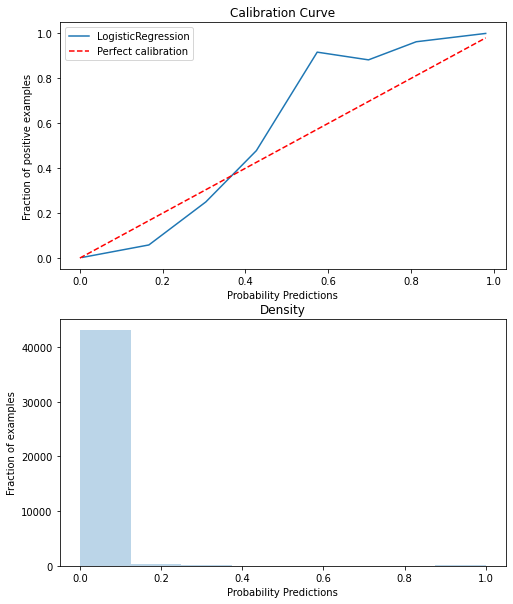

In [9]:
# Logistic Regression

model = logit

model.fit(X_train, y_train)
probs = model.predict_proba(X_test)[:, 1]

plot_calibration_curve(y_test, probs, bins=8, model=model)

As expected, Logistic Regression returns a fairly well calibrated probability.

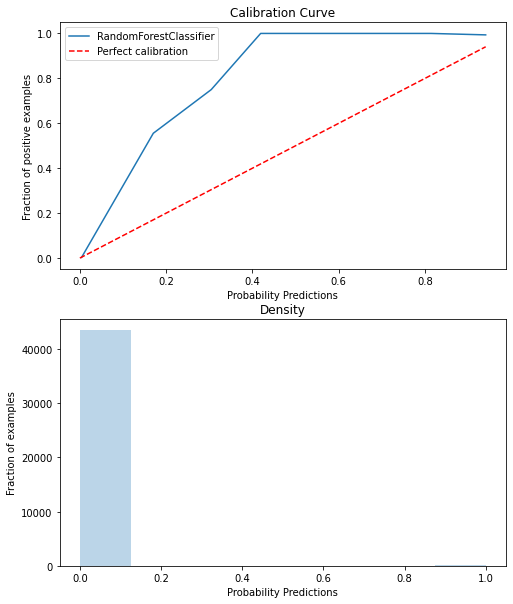

In [10]:
# Random Forests

model = rf

model.fit(X_train, y_train)
probs = model.predict_proba(X_test)[:, 1]

plot_calibration_curve(y_test, probs, bins=8, model=model)

The probability by Random Forests, also as expected, is not so well calibrated.

## Calibration with Under-sampling

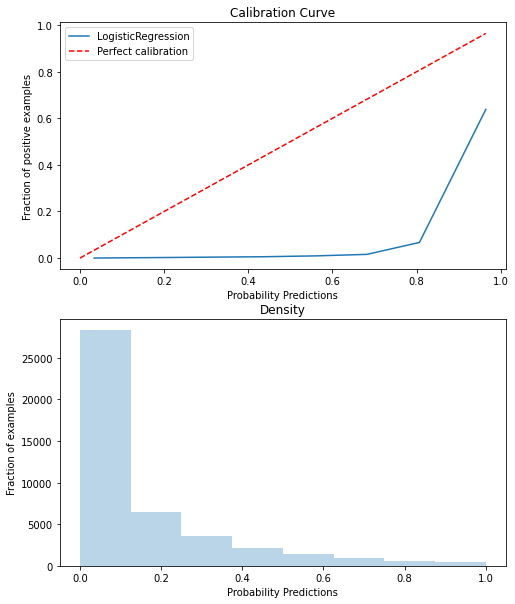

In [11]:
# Logistic Regression

model = logit

model.fit(X_rus, y_rus)
probs = model.predict_proba(X_test)[:, 1]

plot_calibration_curve(y_test, probs, bins=8, model=model)

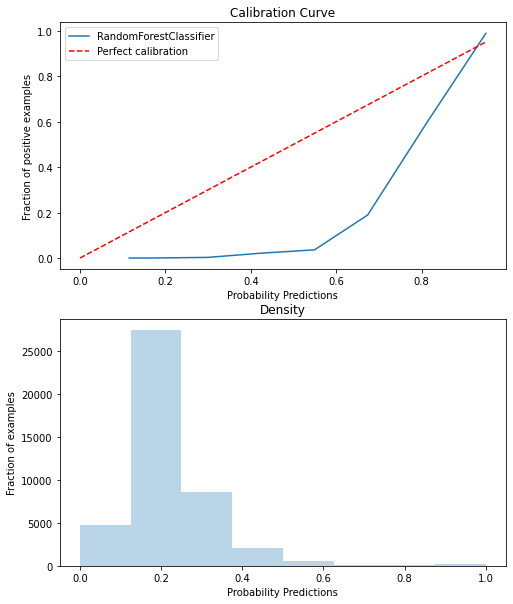

In [12]:
# Random Forests

model = rf

model.fit(X_rus, y_rus)
probs = model.predict_proba(X_test)[:, 1]

plot_calibration_curve(y_test, probs, bins=8, model=model)

As expected, under-sampling distorts the calibration. This is, because the class distributions in train and test set are different.

## Calibration with SMOTE

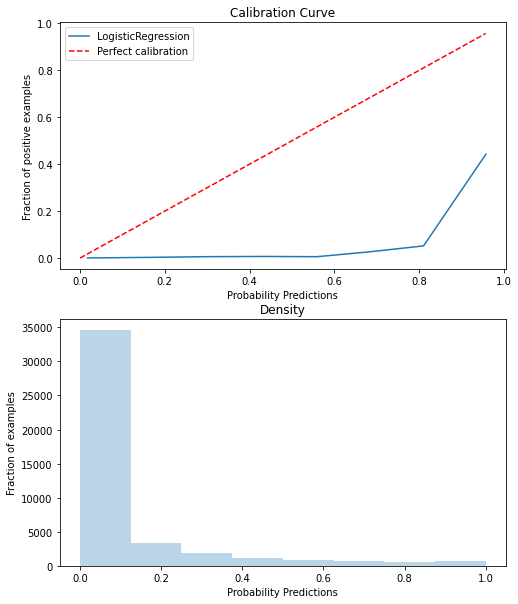

In [13]:
# Logistic Regression

model = logit

model.fit(X_sm, y_sm)
probs = model.predict_proba(X_test)[:, 1]

plot_calibration_curve(y_test, probs, bins=8, model=model)

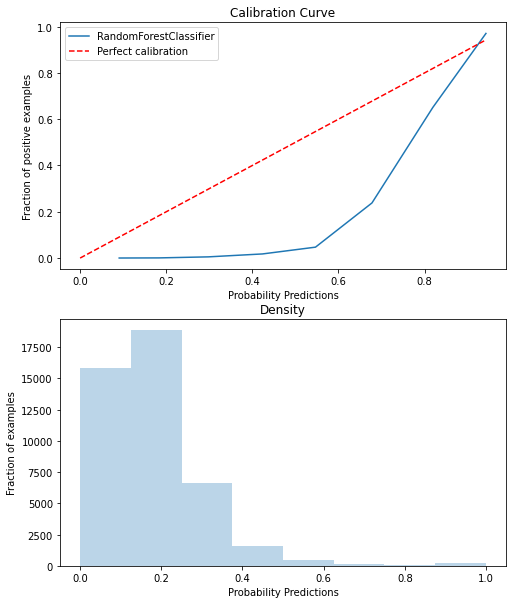

In [14]:
# Random Forests

model = rf

model.fit(X_sm, y_sm)
probs = model.predict_proba(X_test)[:, 1]

plot_calibration_curve(y_test, probs, bins=8, model=model)

As expected, SMOTE distorts the calibration. This is, because the class distributions in train and test set are different.

## Isotonic Re-calibration

### Undersampling

In [15]:
# Logistic Regression

logit.fit(X_rus, y_rus)

clf_isotonic = CalibratedClassifierCV(logit, cv=5, method='isotonic')
clf_isotonic.fit(X_test, y_test)

prob_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]

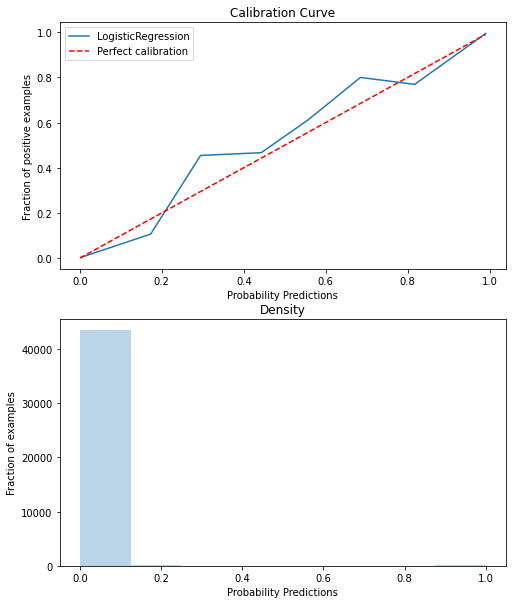

In [16]:
plot_calibration_curve(y_test, prob_isotonic, bins=8, model=logit)

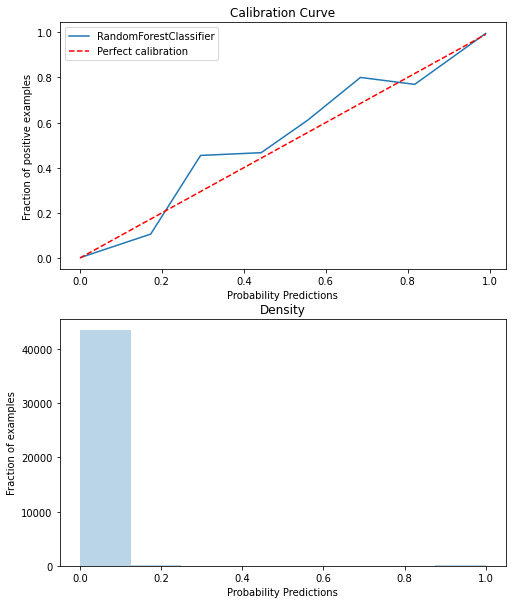

In [17]:
# Random Forests

rf.fit(X_rus, y_rus)

clf_sigmoid = CalibratedClassifierCV(rf, cv=5, method='isotonic')
clf_sigmoid.fit(X_test, y_test)

prob_sigmoid = clf_sigmoid.predict_proba(X_test)[:, 1]

plot_calibration_curve(y_test, prob_isotonic, bins=8, model=rf)

### SMOTE

In [18]:
# Logistic Regression

logit.fit(X_sm, y_sm)

clf_isotonic = CalibratedClassifierCV(logit, cv=5, method='isotonic')
clf_isotonic.fit(X_test, y_test)

prob_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]

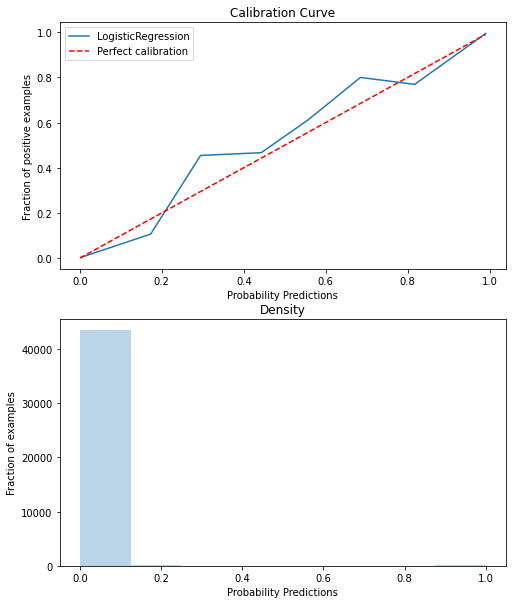

In [19]:
plot_calibration_curve(y_test, prob_isotonic, bins=8, model=logit)

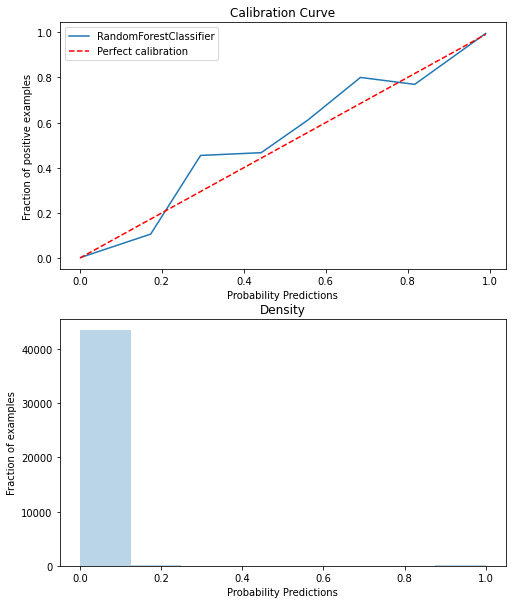

In [20]:
# Random Forests

rf.fit(X_sm, y_sm)

clf_sigmoid = CalibratedClassifierCV(rf, cv=5, method='isotonic')
clf_sigmoid.fit(X_test, y_test)

prob_sigmoid = clf_sigmoid.predict_proba(X_test)[:, 1]

plot_calibration_curve(y_test, prob_isotonic, bins=8, model=rf)

**Remember**: Calibration should be done utilizing the test set, where we have the real distribution of the data.